In [14]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, calculate_mean_and_std
from src.srunet.sru_train import SRUnetTrainer

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'data_with_centers/'
checkpoint_dir = 'checkpoints'
train_percent = 0.737
bio_len = 8
batch_size = 4
upscale_factor = 4
mask_size = 80 * upscale_factor

files = os.listdir(data_path)
train_size = int(train_percent * len(files))
print(train_size)
val_size = len(files) - train_size
train_files, val_files = torch.utils.data.random_split(files, [train_size, val_size])

mean, std = calculate_mean_and_std(data_path, train_files, biosensor_length=bio_len)

train_dataset = BiosensorDataset(data_path, train_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size, augment=True)
val_dataset = BiosensorDataset(data_path, val_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class Args:
    def __init__(self):
        self.batchSize = batch_size
        self.testBatchSize = 1
        self.nEpochs = 5
        self.lr = 0.01
        self.seed = 123
        self.upscale_factor = upscale_factor
        self.in_channels = bio_len
        self.classes = 1

args = Args()

trainer = SRUnetTrainer(args, train_loader, val_loader)


Using device cuda
120


In [16]:
trainer.run()

# model parameters: 8483313

===> Epoch 1 starts:


c:\Users\wittd\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([4, 320, 320])) that is different to the input size (torch.Size([4, 1, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


    Average Loss: 0.0423


c:\Users\wittd\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 320, 320])) that is different to the input size (torch.Size([4, 1, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\wittd\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3, 320, 320])) that is different to the input size (torch.Size([3, 1, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\wittd\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if

    Average PSNR: 17.1441 dB

===> Epoch 2 starts:
    Average Loss: 0.0156
    Average PSNR: 17.1441 dB

===> Epoch 3 starts:
    Average Loss: 0.0155
    Average PSNR: 17.1441 dB

===> Epoch 4 starts:
    Average Loss: 0.0155
    Average PSNR: 17.1441 dB

===> Epoch 5 starts:
    Average Loss: 0.0158
    Average PSNR: 17.1441 dB
Checkpoint saved to checkpoints/sru_save.pth


In [12]:
model = torch.load("checkpoints/sru_save.pth")
model = model.to(device)

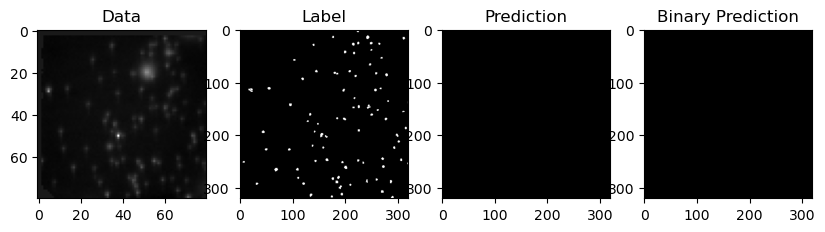

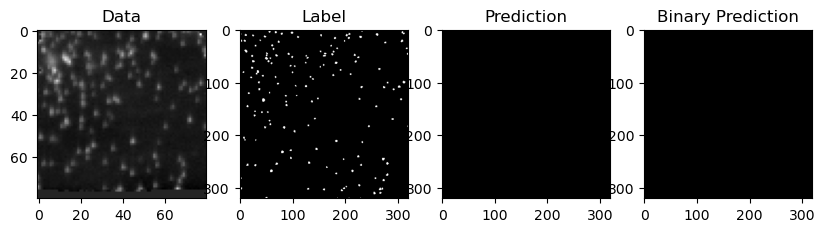

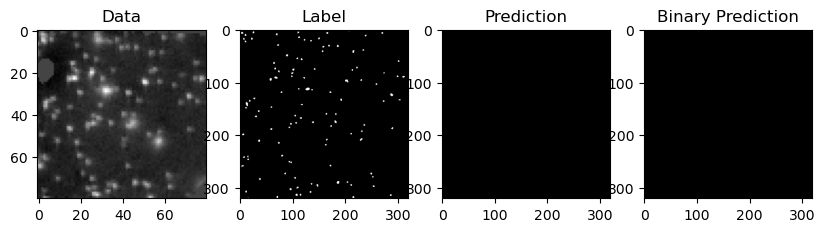

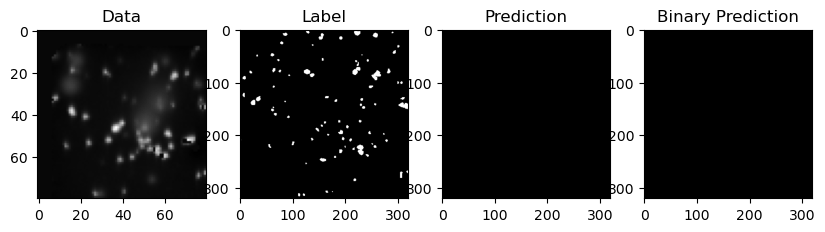

In [13]:
# Load a batch of data and labels
val_loader_iter = iter(val_loader)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)


labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 40))
    
    plt.subplot(1, 4, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')
    
    plt.show()

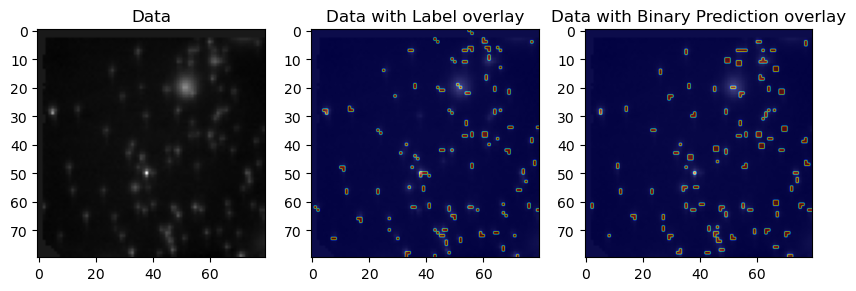

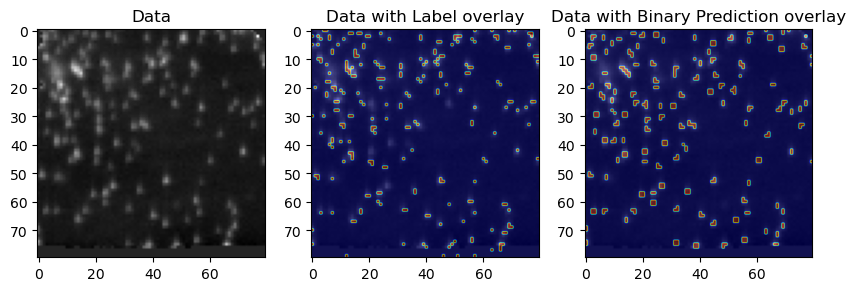

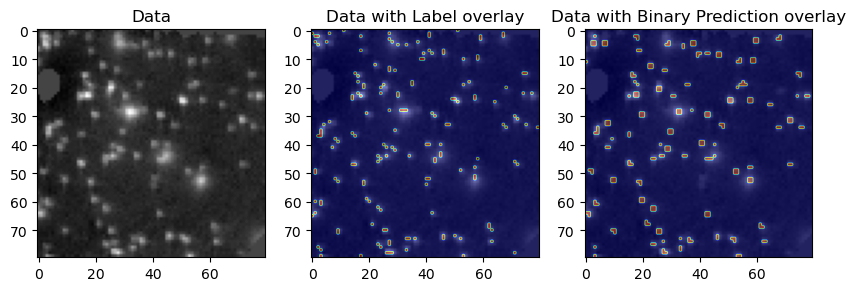

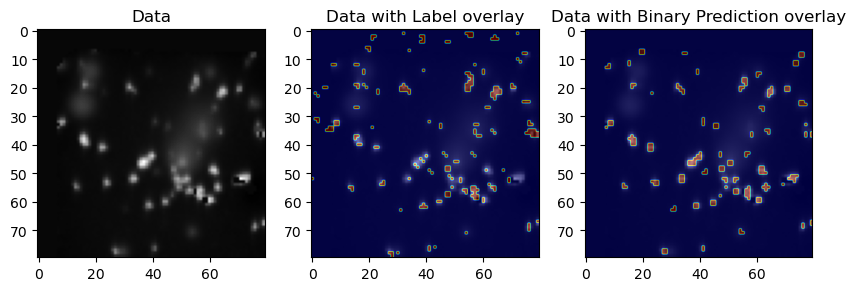

In [ ]:
# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 3, 2)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(labels[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Label overlay')
    
    plt.subplot(1, 3, 3)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Data with Binary Prediction overlay')
    
    plt.show()

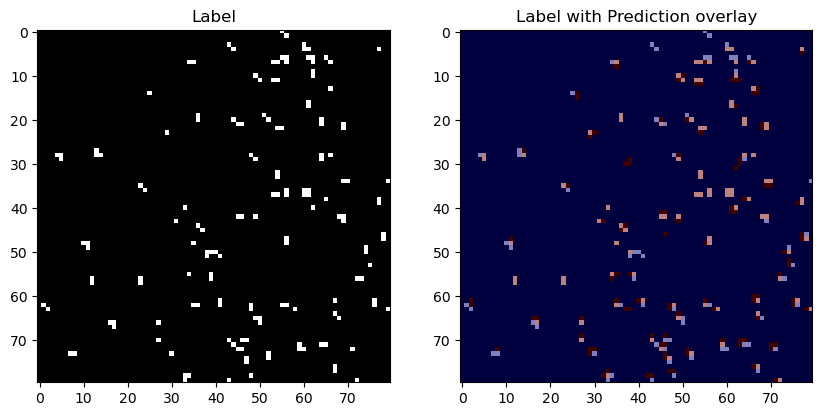

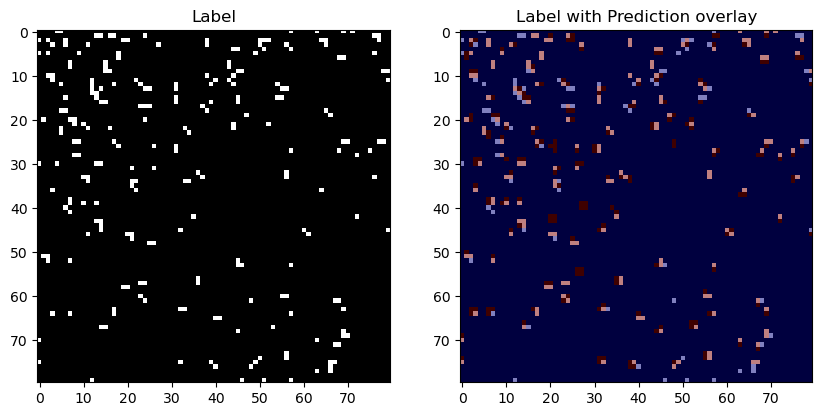

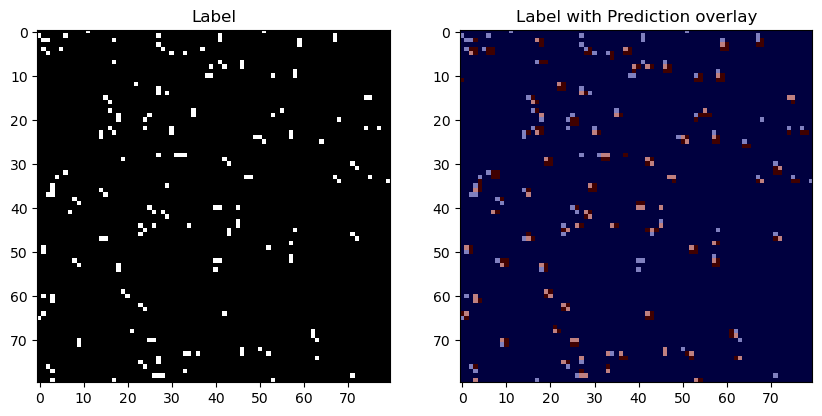

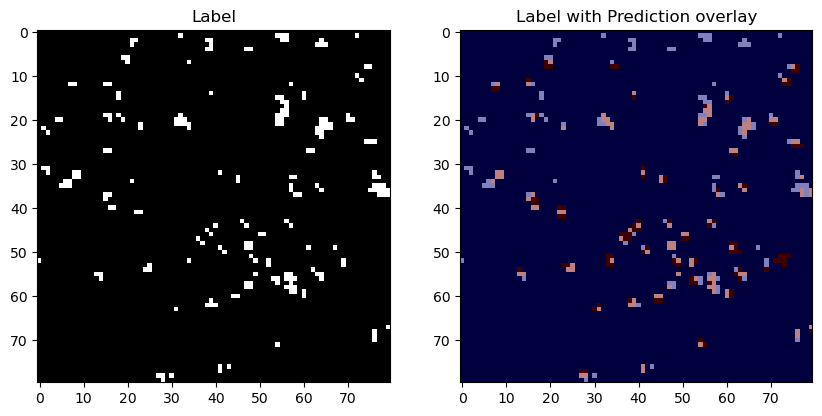

In [ ]:
# Plot the label and the prediction
for i in range(len(labels)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Label with Prediction overlay')
    
    plt.show()

In [ ]:
def cell_detection_skimage(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = skimage.measure.label(binary_predictions[i], return_num=True, connectivity=2)
                _, num_cells_label = skimage.measure.label(labels[i], return_num=True, connectivity=2)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [ ]:
def cell_detection_scipy(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            structure = np.ones((3, 3))

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = scipy.ndimage.label(np.squeeze(binary_predictions[i]), structure=structure)
                _, num_cells_label = scipy.ndimage.label(labels[i], structure=structure)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [ ]:
def pos_pixels(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            total_cells += np.sum(labels)
            detected_cells += np.sum(binary_predictions)

    return total_cells, detected_cells

In [ ]:
label, detected = pos_pixels(model, val_loader, device, threshold=0.5)
print(label, detected)

9438 9898


In [ ]:
cell_detection_rate, total, detected = cell_detection_skimage(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8251101321585903, total cells: 2270, detected cells: 1873


In [ ]:
cell_detection_rate, total, detected = cell_detection_scipy(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.8004405286343612, total cells: 2270, detected cells: 1817
